In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

molecule = "propane"

topfile = molecule + ".top"

parameter_dir = "../topology_code/"

#####################################################################################
# Creating a dictionary containing the info from the topology file
#####################################################################################
terms = ["[AtomTypes]","[Bonds]","[Angles]","[ImproperDihedrals]","[Dihedrals]","[LJ]","[Charges]"]
with open(parameter_dir+topfile) as file:
    lines = []
    for line in file:
        lines.append(line)
    file.close()

def mkdic(lines,terms):
    #create ampty dictionary, that will be filled with the content from the topology file, but only if the entries of the block exist, e.g. if there ar no improper torsions, there will be no key for these in the dictionary
    dic={}
    #iterate through the whole topology file
    line_nr = -1
    for line in lines:
        line_nr += 1
        # check if we are at the start of a new block, corresponding to a particular term, or the initial block declaring AtomTypes
        if line.startswith("[AtomTypes]"):
            #get number of atoms for the given molecule
            natoms = int(line.split()[1])
        for term in terms:
            #if we are at the descriptor line for a new term, e.g. [LJ] or [Angles]
            if line.startswith(term):
                #retrieve the number of entries for each block (e.g. if there are 18 dihedrals, nlines=18)
                if len(line.split()) != 2: #the blocks in the topology file for LJ and charges don't have the number of lines written next to the descriptor
                    nlines=natoms
                else:
                    nlines=int(line.split()[1]) # for all other blocks, the descriptor line (e.g. [Dihedrals] 18) has the number of lines written nect to it
                # add the entries to the dictionary; ONLY if there are entries; otherwise don't even create a key 
                if nlines != 0:
                    dic[term]=[]
                    for i in range(nlines):
                        #print(lines[line_nr+i+1])
                        dic[term].append(lines[line_nr+i+1].split("\t"))
    return dic

dic=mkdic(lines,terms)

#print(dic)



print("\n-----------------------------------------------------------------------")
print("The created dictionary contains the following content\nwith the number of lines written on the right.")
print("The first line of each block given below as well:\n")
for term in dic:
    #print(term,"\n",dic[term])
    print(term,len(dic[term]))
    print(dic[term][0])
    print(dic[term][1])
    print()
print("-----------------------------------------------------------------------")



-----------------------------------------------------------------------
The created dictionary contains the following content
with the number of lines written on the right.
The first line of each block given below as well:

[AtomTypes] 11
['1', 'C', 'CT', '12.01\n']
['2', 'C', 'CT', '12.01\n']

[Bonds] 10
['1', '2', '0.1526', '259408.0\n']
['2', '3', '0.1526', '259408.0\n']

[Angles] 18
['CT-CT-HC', '2', '1', '4', '109.5', '418.4\n']
['CT-CT-HC', '2', '1', '5', '109.5', '418.4\n']

[Dihedrals] 36
['HC-CT-CT-CT', '4', '1', '2', '3', '9', '0.0', '0.66944', '3\n']
['HC-CT-CT-CT', '5', '1', '2', '3', '9', '0.0', '0.66944', '3\n']

[LJ] 11
['1', '3.39967E-01', '4.5773E-01\n']
['2', '3.39967E-01', '4.5773E-01\n']

[Charges] 11
['1', '-0.19018864940136362\n']
['2', '0.07079249039121673\n']

-----------------------------------------------------------------------


## Some security checks
- check the total charge
- check which terms are included, and how many

In [2]:
# check the total charge
charges = dic["[Charges]"]
total_charge = 0
for line in charges:
    total_charge += float(line[1])
print("The molecule has a total charge of %.6f"%total_charge)

#check which terms are included
print("\nThe following terms will be considered:")
for term in dic:
    print(term,len(dic[term]))

The molecule has a total charge of 0.000000

The following terms will be considered:
[AtomTypes] 11
[Bonds] 10
[Angles] 18
[Dihedrals] 36
[LJ] 11
[Charges] 11


# potential energy
\begin{align}
    U 
    &= 
    \underbrace{\sum_{\text{Bonds}} \frac{k_b}{2} (b-b_0)^2}_{U_{bonds}}
    + \underbrace{\sum_{\text{Angles}} \frac{k_{\theta}}{2}  (\theta-\theta_0)^2}_{U_{angles}}
    + \underbrace{\sum_{\text{torsions}} \frac{V_n}{2} \bigl[1+\cos(n\omega-\gamma)\bigr]}_{U_{dihedrals}}
    \nonumber \\ \quad \quad
    &+ \underbrace{\sum_{i=1}^{N-1}\sum_{j=i+1}^{N} 4\epsilon_{ij} \biggl[\biggl(\frac{\sigma_{ij}}{r_{ij}} \biggr)^{12} - \biggl( \frac{\sigma_{ij}}{r_{ij}}\biggr)^{6} \biggr]}_{U_{LJ}}
    + \underbrace{\sum_{i=1}^{N-1}\sum_{j=i+1}^{N} \frac{q_iq_j}{4\pi \epsilon_0 r_{ij}} }_{U_{Coulomb}}
\end{align}

## bond potential
\begin{align}
U_{bonds}(b) = \frac{1}{2} k_b (b-b_0)^2
\end{align}


In [3]:
def plot_U_bonds(dic,entryline, printhere=False):
    atom1=int(dic["[Bonds]"][entryline][0])
    atom2=int(dic["[Bonds]"][entryline][1])
    b0=float(dic["[Bonds]"][entryline][2])
    kb=float(dic["[Bonds]"][entryline][3])
    b=np.linspace(0,0.5) # in nm
    
    atom1_name=dic["[AtomTypes]"][atom1+1][1]
    atom2_name=dic["[AtomTypes]"][atom2+1][1]
    atoms = atom1_name+"-"+atom2_name
    
    atom1_type=dic["[AtomTypes]"][atom1+1][2]
    atom2_type=dic["[AtomTypes]"][atom2+1][2]
    atoms = atom1_type+"-"+atom2_type
    
    U_bonds = 1/2*kb*(b-b0)**2
    
    fig = plt.figure()
    plt.plot(b,U_bonds)
    plt.title("$U_{bonds}(b) = 0.5 \cdot k_b \cdot(b-b_0)^2$\nwith $k_b$=%.1f kJ mol$^{-1}$nm$^{-2}$ and $b_0$=%.4f nm"%(kb,b0))
    plt.xlabel("$b_{%s}$ / nm"%atoms)
    plt.ylabel("$U_{bonds}$ / kJ mol$^{-1}$")
    #plt.close()
    
    plt.xlim([0,0.5])
    plt.ylim([0,1e4])
    
    plt.savefig("%s_U_bonds.png"%molecule, dpi=300)
    if printhere==False:
        plt.close()
    return

In [4]:
plot_U_bonds(dic,6, printhere=False)

## angle potential
\begin{align}
U_{angles} (\theta)= \frac{1}{2} k_{\theta} (\theta-\theta_0)^2
\end{align}

In [5]:
def plot_U_angles(dic,entryline,printhere=False):
    atoms=dic["[Angles]"][entryline][0]
    th0=float(dic["[Angles]"][entryline][4])
    cth=float(dic["[Angles]"][entryline][5])
    th=np.linspace(0,360,361) # in deg
    
    U_angles = 1/2*cth*(th-th0)**2
    
    fig = plt.figure()
    plt.plot(th,U_angles)
    plt.title("$U_{angles}(θ) = 0.5 \cdot k_{θ} \cdot(θ-θ_0)^2$\nwith $k_{θ}$=%.1f kJ mol$^{-1}$deg$^{-2}$ and $θ_0$=%.4f deg"%(cth,th0))
    plt.xlabel("$θ_{%s}$ / deg"%atoms)
    plt.ylabel("$U_{angles}$ / kJ mol$^{-1}$")
    
    plt.xlim([0,360])
    plt.ylim([0,2e7])

    plt.savefig("%s_U_angles.png"%molecule, dpi=300)
    if printhere==False:
        plt.close()
    return


In [6]:
plot_U_angles(dic,6,printhere=False)

# torsional potential
\begin{align}
    U_{dihedrals} (\phi)= 
     \frac{\text{barrierterm}}{\text{div}} \bigl[1-\cos(\text{periodicity} \cdot \phi+ \text{phase})\bigr]
\end{align}

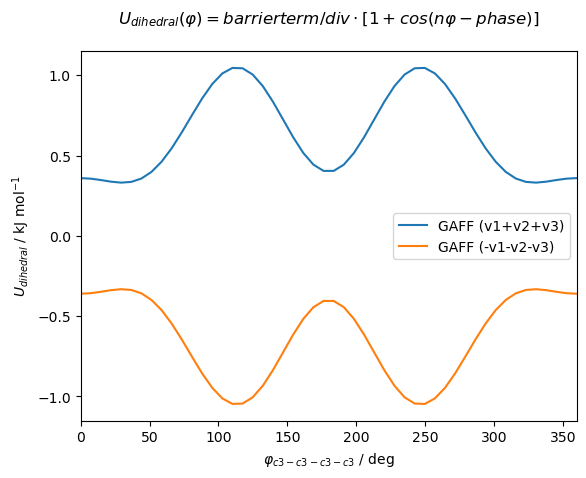

In [34]:
def plot_U_dihedral(dic,entryline,printhere=False):
    phi=np.linspace(0,360) # in deg
    
    atoms=dic["[Dihedrals]"][entryline][0]
    
    div=int(dic["[Dihedrals]"][entryline][5])
    phase=float(dic["[Dihedrals]"][entryline][6]) #phase /deg
    barrier_term=float(dic["[Dihedrals]"][entryline][7]) 
    periodicity=int(dic["[Dihedrals]"][entryline][8])

    ## GAFF 2
    #hc-c3-c3-hc   1    0.120         0.000           3.000      m1-2021
    atoms = "hc-c3-c3-hc"
    div = 1
    barrier_term = 0.120
    phase = 0
    periodicity = 3

    #c3-c3-c3-hc   1    0.130         0.000           3.000      x73-2021
    atoms="c3-c3-c3-hc"
    div=1
    barrier_term=0.130
    phase=0.000
    periodicity=3.000

    #c3-c3-c3-c3   1    0.520         0.000           3.000      c42-2021
    atoms="c3-c3-c3-c3"
    div=1
    barrier_term=0.520
    phase=0.000
    periodicity=3.000
    U_dihedral_gaff2 = barrier_term/div*(1+np.cos((periodicity*phi-phase)/360*(2*np.pi)))
    


    #### GAFF
    #c3-c3-c3-c3   1    0.18          0.0            -3.         Junmei et al, 1999
    atoms="c3-c3-c3-c3"   
    div=1
    barrier_term=0.18
    phase=0.0
    periodicity=-3.000
    U_dihedral_1 = barrier_term/div*(1+np.cos((periodicity*phi-phase)/360*(2*np.pi)))
    
    
    #c3-c3-c3-c3   1    0.25        180.0            -2.         Junmei et al, 1999
    atoms = "c3-c3-c3-c3"
    div=1
    barrier_term=0.25
    phase=180.0
    periodicity=-2.000
    U_dihedral_2 = barrier_term/div*(1+np.cos((periodicity*phi-phase)/360*(2*np.pi)))
    
    
    #c3-c3-c3-c3   1    0.20        180.0             1.         Junmei et al, 1999
    atoms="c3-c3-c3-c3"
    div=1
    barrier_term=0.20
    phase=180.0
    periodicity=1.000

    U_dihedral_3 = barrier_term/div*(1+np.cos((periodicity*phi-phase)/360*(2*np.pi)))
    
    
    plt.figure()
    #plt.plot(phi,U_dihedral_gaff2,label="GAFF2")
    #plt.plot(phi,U_dihedral_1,label="GAFF (v1)")
    #plt.plot(phi,U_dihedral_2,label="GAFF (v2)")
    #plt.plot(phi,U_dihedral_3,label="GAFF (v3)")
    plt.plot(phi,U_dihedral_1+U_dihedral_2+U_dihedral_3,label="GAFF (v1+v2+v3)")
    plt.plot(phi,-U_dihedral_1-U_dihedral_2-U_dihedral_3,label="GAFF (-v1-v2-v3)")
    #plt.plot(phi,U_dihedral_1*U_dihedral_2*U_dihedral_3,label="GAFF (v1*v2*v3)")
    moretext="with $barrierterm$=%.3f kJ mol$^{-1}$;div=%i $n=%.3f$; $δ$=%.4f deg"%(barrier_term,div,periodicity,phase)
    plt.title("$U_{dihedral}(φ) = barrierterm/div \cdot[1+cos(nφ-phase)]$\n")
    plt.xlabel("$φ_{%s}$ / deg"%atoms)
    plt.ylabel("$U_{dihedral}$ / kJ mol$^{-1}$")

    plt.legend()
    plt.xlim([0,360])
    #plt.ylim([0,2e7])
    plt.savefig("%s_U_dihedral.png"%molecule, dpi=300)
    if printhere==False:
        plt.close()
    
    return

plot_U_dihedral(dic,6,printhere=True)
    

In [22]:
#plot_U_dihedral(dic,6,printhere=True)

## improper torsional potential
\begin{align}
    U_{dihedrals} (\phi)= 
     \frac{\text{barrierterm}}{\text{div}} \bigl[1-\cos(\text{periodicity} \cdot \phi+ \text{phase})\bigr]
\end{align}

In [9]:
def plot_U_impdihedral(dic,entryline, printhere=False):
    atoms=dic["[ImproperDihedrals]"][entryline][0]
    div=int(dic["[ImproperDihedrals]"][entryline][5])
    phase=float(dic["[ImproperDihedrals]"][entryline][6]) #phase /deg
    barrier_term=float(dic["[ImproperDihedrals]"][entryline][7]) 
    periodicity=int(dic["[ImproperDihedrals]"][entryline][8])
    
    phi=np.linspace(0,360) # in deg
    
    U_impdihedral = barrier_term/div*(1+np.cos((periodicity*phi-phase)/360*(2*np.pi)))
    
    plt.figure()
    plt.plot(phi,U_impdihedral)
    plt.title("$U_{impdihedral}(φ) = barrierterm/div \cdot[1+cos(nφ-δ)]$\nwith $barrierterm$=%.3f kJ mol$^{-1}$;div=%i $n=%.3f$; $δ$=%.4f deg"%(barrier_term,div,periodicity,phase))
    plt.xlabel("$φ_{%s}$ / deg"%atoms)
    plt.ylabel("$U_{impdihedral}$ / kJ mol$^{-1}$")
    
    plt.xlim([0,360])
    #plt.ylim([0,2e7])
    plt.savefig("%s_U_impdihedral.png"%molecule, dpi=300)
    
    if printhere==False:
        plt.close()
    return



In [10]:
#plot_U_impdihedral(dic,6,printhere=True)

## LJ potential
\begin{align}
U_{LJ}(r_{ij}) = 4\epsilon_{ij} \biggl[\biggl(\frac{\sigma_{ij}}{r_{ij}} \biggr)^{12} - \biggl( \frac{\sigma_{ij}}{r_{ij}}\biggr)^{6} \biggr]
\end{align}

In [11]:
def plot_U_LJ(dic,entrylines,printhere=False):
    atom_i = entrylines[0]
    atom_j = entrylines[1]
    
    atom_nr_i=int(dic["[LJ]"][atom_i][0])
    atom_type_i=dic["[AtomTypes]"][atom_nr_i-1][2]
    sigma_ii=float(dic["[LJ]"][atom_i][1])
    eps_ii=float(dic["[LJ]"][atom_i][2])
    
    atom_nr_j=int(dic["[LJ]"][atom_j][0])
    atom_type_j=dic["[AtomTypes]"][atom_nr_j-1][2]
    sigma_jj=float(dic["[LJ]"][atom_j][1])
    eps_jj=float(dic["[LJ]"][atom_j][2])
    
    #print(atom_nr_i, atom_type_i,sigma_ii,eps_ii)
    #print(atom_nr_j, atom_type_j,sigma_jj,eps_jj)
    
    #Lorentz-Berthelot mixing rules:
    eps_ij = np.sqrt(eps_ii*eps_jj)
    sigma_ij = 0.5*(sigma_ii+sigma_jj)
    
    
    r_ij=np.linspace(-0.5,5,1001) # in nm
    
    U_LJ = 4 * eps_ij * ((sigma_ij/r_ij)**12 - (sigma_ij/r_ij)**6)
    
    plt.figure()
    plt.plot(r_ij,U_LJ)
    moretext1 = "\n$ε_{ii}=%.3f$ kJ/mol; $σ_{ii} =$%.3f nm; (i=%s)"%(eps_ii,sigma_ii, atom_type_i)
    moretext2 = "\n$ε_{jj}=%.3f$ kJ/mol; $σ_{jj} =$%.3f nm; (j=%s)"%(eps_jj,sigma_jj, atom_type_j)
    plt.title("$U_{LJ}(r_{ij}) = 4 ε_{ij} [ (σ_{ij}/r_{ij})^{12} - (σ_{ij}/r_{ij})^6 ]$ \n with $ε_{ij} = \sqrt{ε_{ii}\cdot ε_{jj}}$= %.3f kJ/mol and $σ_{ij} = 0.5 (σ_{ii}+σ_{jj})$ =%.3f nm \n"%(eps_ij,sigma_ij)+moretext1+moretext2)
    plt.xlabel("$r_{%s}$ / nm"%(atom_type_i+"-"+atom_type_j))
    plt.ylabel("$U_{LJ}$ / kJ mol$^{-1}$")
    
    plt.xlim([0.2,1])
    plt.ylim([-0.3,0.5])
    #plt.close()
    
    plt.savefig("U_LJ.png", dpi=300)
    if printhere==False:
        plt.close()    
    return

In [12]:
plot_U_LJ(dic,[1,6],printhere=False)

## Coulomb potential
\begin{align}
U_{Coulomb}(r_{ij})= \frac{q_iq_j}{4\pi \epsilon_0 r_{ij}} 
\end{align}

In [13]:
def plot_U_Coulomb(dic,entrylines,printhere=False):
    #entrylines=[0,1]
    atom_i = entrylines[0]
    atom_j = entrylines[1]
    
    atom_nr_i=int(dic["[Charges]"][atom_i][0])
    atom_type_i=dic["[AtomTypes]"][atom_nr_i-1][2]
    q_i=float(dic["[Charges]"][atom_i][1]) # in fraction of e
    
    atom_nr_j=int(dic["[Charges]"][atom_j][0])
    atom_type_j=dic["[AtomTypes]"][atom_nr_j-1][2]
    q_j=float(dic["[Charges]"][atom_j][1]) # in fraction of e
    
    print(atom_type_i,q_i)
    print(atom_type_j,q_j)
    eps_0_SI = 8.8541878188e-12 #Si units: C^2/(J*m)
    e_SI = 1.602176634e-19 #SI units: C
    
    eps_0 = eps_0_SI * 10**(-6) # in C^2/(kJ*nm)
    eps_0 = eps_0 / (e_SI)**2 # in e^2/(kJ*nm)
    print(1/(4* np.pi* eps_0))
    
    r_ij=np.linspace(-0.5,10,1001) # in nm
    U_Coulomb = 1/(4* np.pi* eps_0) * q_i*q_j/r_ij
    
    plt.figure()
    plt.plot(r_ij,U_Coulomb)
    plt.title("$U_{Coulomb}(r_{ij}) = 1/(4πε_0) \cdot q_i q_j/r_{ij} $ \n with $q_{i} = %.3f e$ and $q_{j} =%.3f e$ \n"%(q_i,q_j))
    plt.xlabel("$r_{%s}$ / nm"%(atom_type_i+"-"+atom_type_j))
    plt.ylabel("$U_{Coulomb}$ / kJ mol$^{-1}$")

    plt.xlim([0,4])
    plt.savefig("%s_U_Coulomb.png"%molecule, dpi=300)

    if printhere==False:
        plt.close()
    return

In [14]:
plot_U_Coulomb(dic,[1,6],printhere=False)

CT 0.07079249039121673
HC -0.024958797579555877
2.3070775507783552e-22
